<a href="https://colab.research.google.com/github/mofuoku417/Univariate_Crude_Palm_Oil_Price_Prediction/blob/main/Crude_PalmOil_Price_Prediction_using_MLP_Regression_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


> **Predict Monthly Crude Palm Oil Price  with   Deep Learning (Multi-layer Perception Univariate Time series)**


> Project Objective:

> Design and Build an MLP in tensorflow to predict Monthly Crude Palm Oil Price


  * Data range: 1993 - 2022

  The dataset is a CSV format with: 

  1. Monthly timestamp
  2. Monthly Crude Palm Oil Prices

---------------------------------------------


1. Project Overview and Import Libraries
2. Load and Inspect Monthly Crude Oil Price History
1. Data Preprocessing
2. Build the MLP model
1. Train the MLP
2. Plot Metrics and Evaluate the Model
2. Monthly Crude Palm Oil Prices
2. Visualize the predictions

###Load the Required Libraries

In [128]:
import math 
import numpy as np # Python's fundamental package for scientific computing
import pandas as pd # For data analysis and manipulation
from datetime import date, timedelta # Date Operations
import matplotlib.pyplot as plt # To aid in visualizing
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates # Date formatting
from sklearn.metrics import mean_absolute_error, mean_squared_error # To assess model performance error computation
from sklearn.preprocessing import MinMaxScaler # to standardize the crude palm oil price data 
from tensorflow.keras.models import Sequential # Deep learning library, that is used in neural networks
#from tensorflow.keras.layers import LSTM, Dense # Deep learning classes for densely linked recurrent and regular layers
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Activation, Dense
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from pandas import read_csv
import seaborn as sns
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
import random
random.seed(1) #Making this script reproducible

In [83]:
# Establishing a timetable for data extraction
today = date.today()
end_date = today.strftime("%Y-%m")
start_date = '1993-03'

featurename = 'Price'

#Load dataset
path = 'https://raw.githubusercontent.com/mofuoku417/Univariate_Crude_Palm_Oil_Price_Prediction/main/Data/data.csv'
df = read_csv(path, parse_dates=True)

In [84]:
# Examining the dataset's structure
print(df.shape)
df.head(5)

(361, 3)


,Month,Price,Change
0,1993-03,408,-
1,1993-04,392,-3.92%
2,1993-05,371,-5.36%
3,1993-06,356,-4.04%
4,1993-07,362,1.69%


In [85]:
#Removing the change since it is not needed
del df['Change']
df.head(5)

,Month,Price
0,1993-03,408
1,1993-04,392
2,1993-05,371
3,1993-06,356
4,1993-07,362


In [86]:
#Checking data types
df.dtypes

Month    object
Price    object
dtype: object

In [87]:
#Renaming Price to cpo_pri (Crude palm oil price)
df.rename({'Price': 'cpo_pri', 'Month': 'date'}, axis=1, inplace=True)
df

,date,cpo_pri
0,1993-03,408
1,1993-04,392
2,1993-05,371
3,1993-06,356
4,1993-07,362
...,...,...
356,2022-11,945.74
357,2022-12,940.39
358,2023-01,941.97
359,2023-02,949.98


In [63]:
# converting column "Price" of the DataFrame to numeric
#df["cpo_pri"] = pd.to_numeric('cpo_pri', errors='coerce')

#df.dtypes

In [88]:
df.head(5)

,date,cpo_pri
0,1993-03,408
1,1993-04,392
2,1993-05,371
3,1993-06,356
4,1993-07,362


In [89]:
# Converting date column from object to date format
df['date'] = pd.to_datetime(df['date'].apply(lambda x: x.split()[0])) # Selecting only date
df.set_index('date',drop=True,inplace=True) # Setting date column as index
df.head()

,cpo_pri
date,
1993-03-01,408
1993-04-01,392
1993-05-01,371
1993-06-01,356
1993-07-01,362


In [93]:
df['cpo_pri'] = df['cpo_pri'].apply(lambda x: float(x.split()[0].replace(',', '')))
print(df.dtypes)

cpo_pri    float64
dtype: object


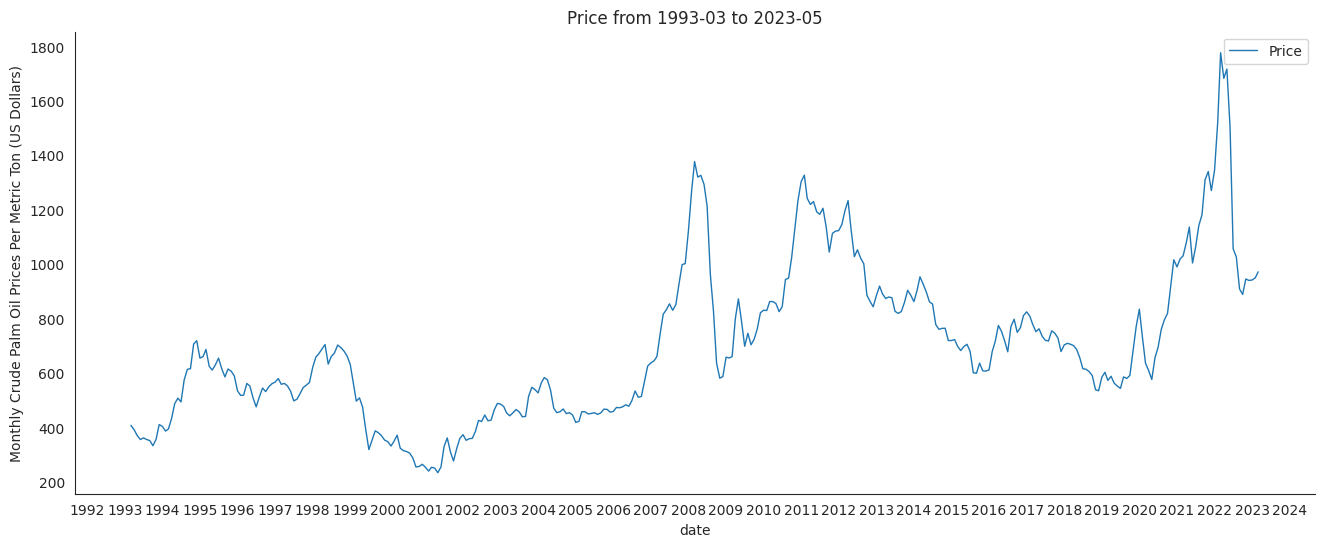

In [94]:
# Constructing a Lineplot
years = mdates.YearLocator() 
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.xaxis.set_major_locator(years)
ax1.legend([featurename], fontsize=12)
plt.title(featurename + ' from '+ start_date + ' to ' + end_date)
sns.lineplot(data=df['cpo_pri'], label=featurename, linewidth=1.0)
plt.ylabel('Monthly Crude Palm Oil Prices Per Metric Ton (US Dollars)')
plt.show()

### Checking for Duplicates

In [99]:
# Check number of duplicates while ignoring the index feature
n_duplicates = df.drop(labels=["cpo_pri"], axis=1).duplicated().sum()
print(f"You seem to have {n_duplicates} duplicates in your database.")

You seem to have 0 duplicates in your database.


###Checking for Missing values

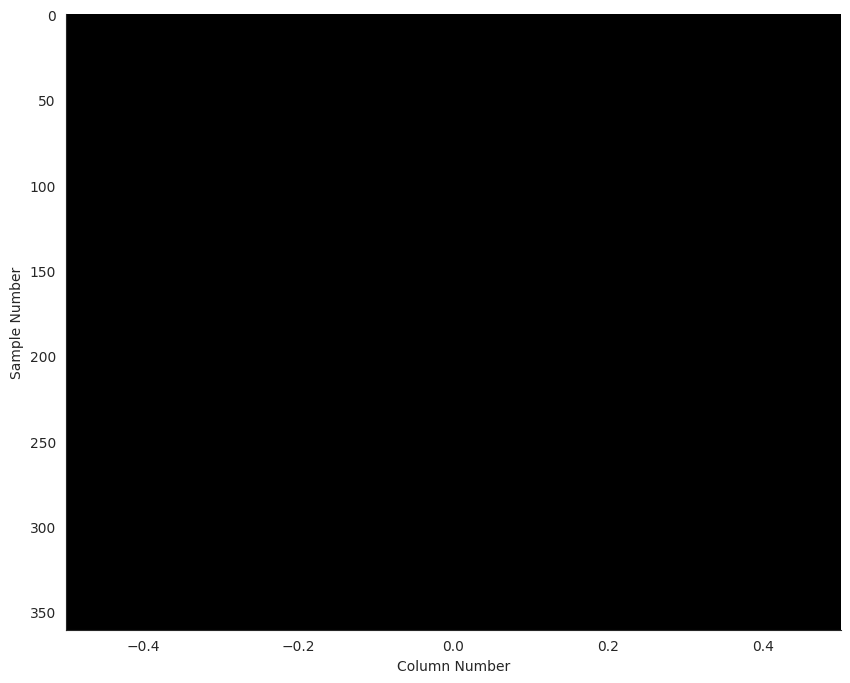

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number");

This figure shows that there are no missing data

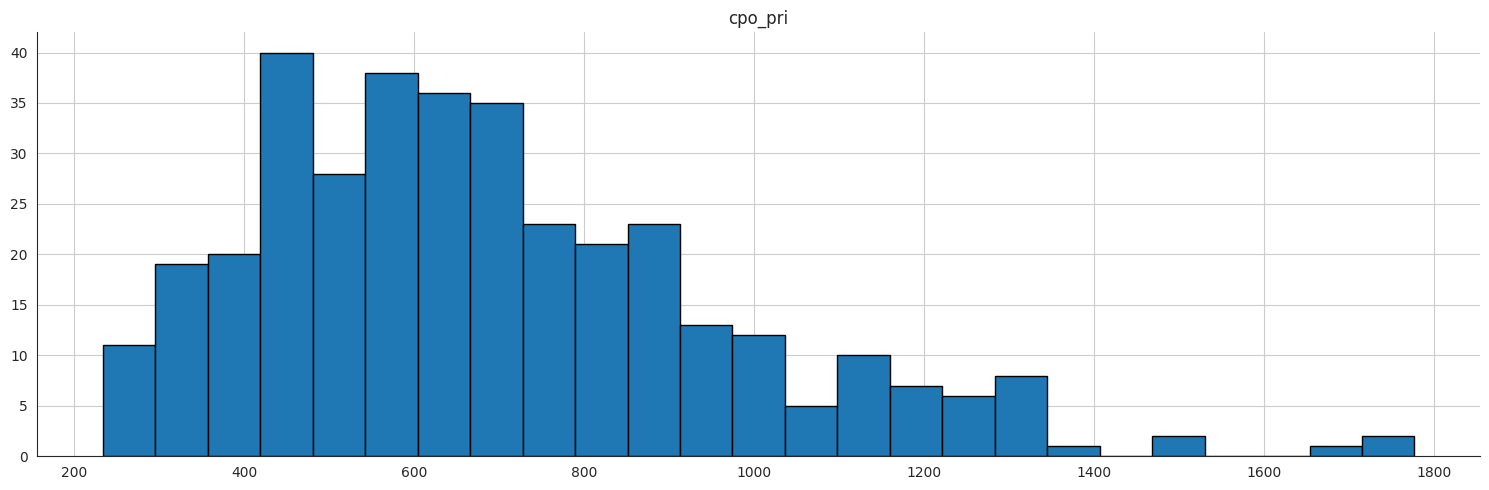

In [106]:
# Plots the histogram for each numerical feature in a separate subplot
df.hist(bins=25, figsize=(15, 5), edgecolor="black")
plt.tight_layout();

###Checking for Outliers

In [107]:
#Computing the percentage of Outliers
for k, v in df.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(df)[1]
        print("Column %s outliers = %.2f%%" % (k, perc))

Column cpo_pri outliers = 500.00%


<Figure size 1500x1500 with 0 Axes>

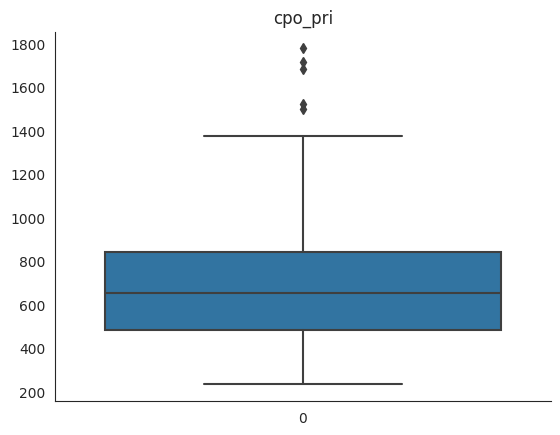

<Figure size 1500x1500 with 0 Axes>

In [111]:
#Ploting the boxplot of the Outliers
sns.boxplot(df['cpo_pri'])
plt.title('cpo_pri')
plt.figure(figsize=(15,15))

###Removing the Outliers

In [113]:
IQR=df.cpo_pri.quantile(0.75)-df.cpo_pri.quantile(0.25)
lower_bridge=df.cpo_pri.quantile(0.25)-(IQR*1.5)
upper_bridge=df.cpo_pri.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-57.3449999999998 1385.495


In [115]:
df.loc[df['cpo_pri']>= 1385.495,'cpo_pri']= 1385.495
df.loc[df['cpo_pri']<= -57.3449999999998,'cpo_pri']= -57.3449999999998

###Ploting of Target variable without Outliers

<Figure size 1000x1000 with 0 Axes>

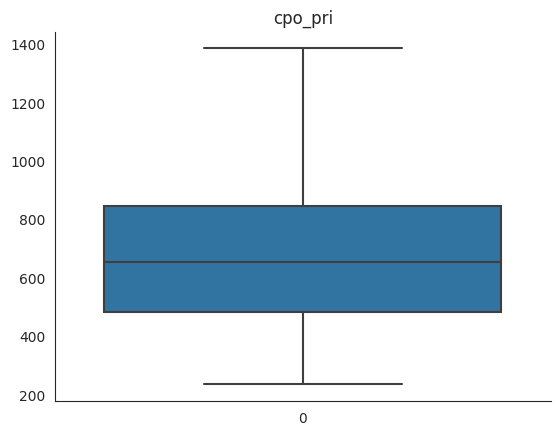

<Figure size 1000x1000 with 0 Axes>

In [118]:
sns.boxplot(df['cpo_pri'])
plt.title('cpo_pri')
plt.figure(figsize=(10,10))    

In [119]:
# Target Selection 
train_df = df.filter(['cpo_pri'])
data_unsc = train_df.values # data_unscaled data

# Compute the number of rows required to train the model on 80% of the data. 
train_data_len = math.ceil(len(data_unsc) * 0.7)

# Scale the characteristic to a value between 0 and 1 to transform it.
mmscaler = MinMaxScaler(feature_range=(0, 1))
np_data = mmscaler.fit_transform(data_unsc)

In [120]:
# Set the sequence len - the period for making a single forecast.
sequence_len = 3

# Index of Prediction
index_cpo_pri = train_df.columns.get_loc("cpo_pri")
print(index_cpo_pri)
# Divide the training data into train and train data sets.
# In the first stage, we determine the number of rows required to train the model on 80% of the data. 
train_data_len = math.ceil(np_data.shape[0] * 0.8)

# Generate training and test data.
train_data = np_data[0:train_data_len, :]
test_data = np_data[train_data_len - sequence_len:, :]

# The MLP model requires data in the following formats: [samples, time steps, features].
def partition_dataset(sequence_len, train_df):
    x, y = [], []
    data_len = train_df.shape[0]
    for i in range(sequence_len, data_len):
        x.append(train_df[i-sequence_len:i,:]) 
        y.append(train_df[i, index_cpo_pri]) 
    
    # Convert the x and y variables to numpy arrays.
    x = np.array(x)
    y = np.array(y)
    return x, y

# Create training and testing data.
X_train, y_train = partition_dataset(sequence_len, train_data)
X_test, y_test = partition_dataset(sequence_len, test_data)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Verify that the prediction value and the input value match
print(X_test[1][sequence_len-1][index_cpo_pri])
print(y_test[0])

0
(286, 3, 1) (286,)
(72, 3, 1) (72,)
0.44990208381278246
0.44990208381278246


In [121]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model = Sequential()
model.add(Dense(8, input_dim=sequence_len, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
143/143 - 1s - loss: 0.0282 - 652ms/epoch - 5ms/step
Epoch 2/200
143/143 - 0s - loss: 0.0069 - 168ms/epoch - 1ms/step
Epoch 3/200
143/143 - 0s - loss: 0.0043 - 173ms/epoch - 1ms/step
Epoch 4/200
143/143 - 0s - loss: 0.0033 - 196ms/epoch - 1ms/step
Epoch 5/200
143/143 - 0s - loss: 0.0031 - 335ms/epoch - 2ms/step
Epoch 6/200
143/143 - 0s - loss: 0.0029 - 248ms/epoch - 2ms/step
Epoch 7/200
143/143 - 0s - loss: 0.0029 - 265ms/epoch - 2ms/step
Epoch 8/200
143/143 - 0s - loss: 0.0028 - 246ms/epoch - 2ms/step
Epoch 9/200
143/143 - 0s - loss: 0.0028 - 258ms/epoch - 2ms/step
Epoch 10/200
143/143 - 0s - loss: 0.0027 - 246ms/epoch - 2ms/step
Epoch 11/200
143/143 - 0s - loss: 0.0026 - 247ms/epoch - 2ms/step
Epoch 12/200
143/143 - 0s - loss: 0.0026 - 264ms/epoch - 2ms/step
Epoch 13/200
143/143 - 0s - loss: 0.0025 - 245ms/epoch - 2ms/step
Epoch 14/200
143/143 - 0s - loss: 0.0024 - 241ms/epoch - 2ms/step
Epoch 15/200
143/143 - 0s - loss: 0.0024 - 213ms/epoch - 1ms/step
Epoch 16/200
143/14

In [122]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=2,verbose=1, callbacks=[callback])

Epoch 1/200
143/143 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 2/200
143/143 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 3/200
143/143 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 4/200
143/143 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 5/200
143/143 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 6/200
143/143 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 7/200
143/143 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 8/200
143/143 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 9/200
143/143 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 10/200
143/143 [==============================] - 0s 2ms/step - loss: 0.0013 - val_lo

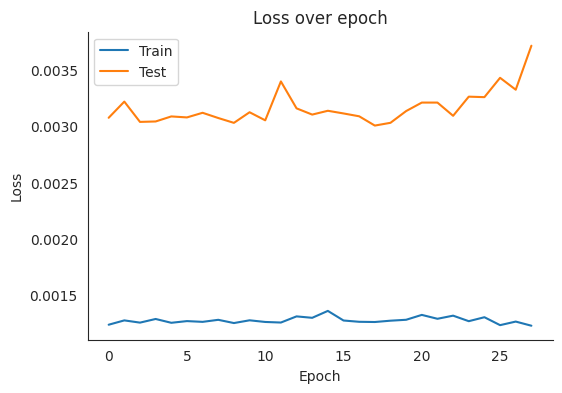

In [123]:
plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Test")
plt.title("Loss over epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [124]:
# Obtain the predicted values
mlp_pred_scaled = model.predict(X_test)
mlp_pred = mmscaler.inverse_transform(mlp_pred_scaled)
y_test_unsc = mmscaler.inverse_transform(y_test.reshape(-1, 1))

3/3 [==============================] - 0s 4ms/step


In [125]:
# Mean Absolute Error (MAE)
mlp_MAE = mean_absolute_error(y_test_unsc, mlp_pred)
print(f'Median Absolute Error (MAE): {np.round(mlp_MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
mlp_MAPE = np.mean((np.abs(np.subtract(y_test_unsc, mlp_pred)/ y_test_unsc))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(mlp_MAPE, 2)} %')

# Root Mean Squared Error (RMSE)
mlp_RMSE = mean_squared_error(y_test_unsc, mlp_pred) ** 0.5
print(f'Root Mean Squared Error (RMSE): {np.round(mlp_RMSE, 2)} %')

# Mean Squared Error (MSE)
mlp_MSE = mean_squared_error(y_test_unsc, mlp_pred)
print('MSE value of the MLP Model:', mlp_MSE )

# r2_score
mlp_r2 = r2_score(y_test_unsc, mlp_pred)
print(f'R^2 Score: {np.round(mlp_r2, 2)} %')

Median Absolute Error (MAE): 43.12
Mean Absolute Percentage Error (MAPE): 5.09 %
Root Mean Squared Error (RMSE): 63.14 %
MSE value of the MLP Model: 3986.691818312564
R^2 Score: 0.94 %


In [126]:
train = pd.DataFrame(train_df[:train_data_len + 1]).rename(columns={'cpo_pri': 'X_train'})
train

,X_train
date,
1993-03-01,408.00
1993-04-01,392.00
1993-05-01,371.00
1993-06-01,356.00
1993-07-01,362.00
...,...
2016-12-01,811.38
2017-01-01,825.00
2017-02-01,808.61


<Axes: title={'center': 'MLP Predictions vs Actual'}, xlabel='date', ylabel='Price'>

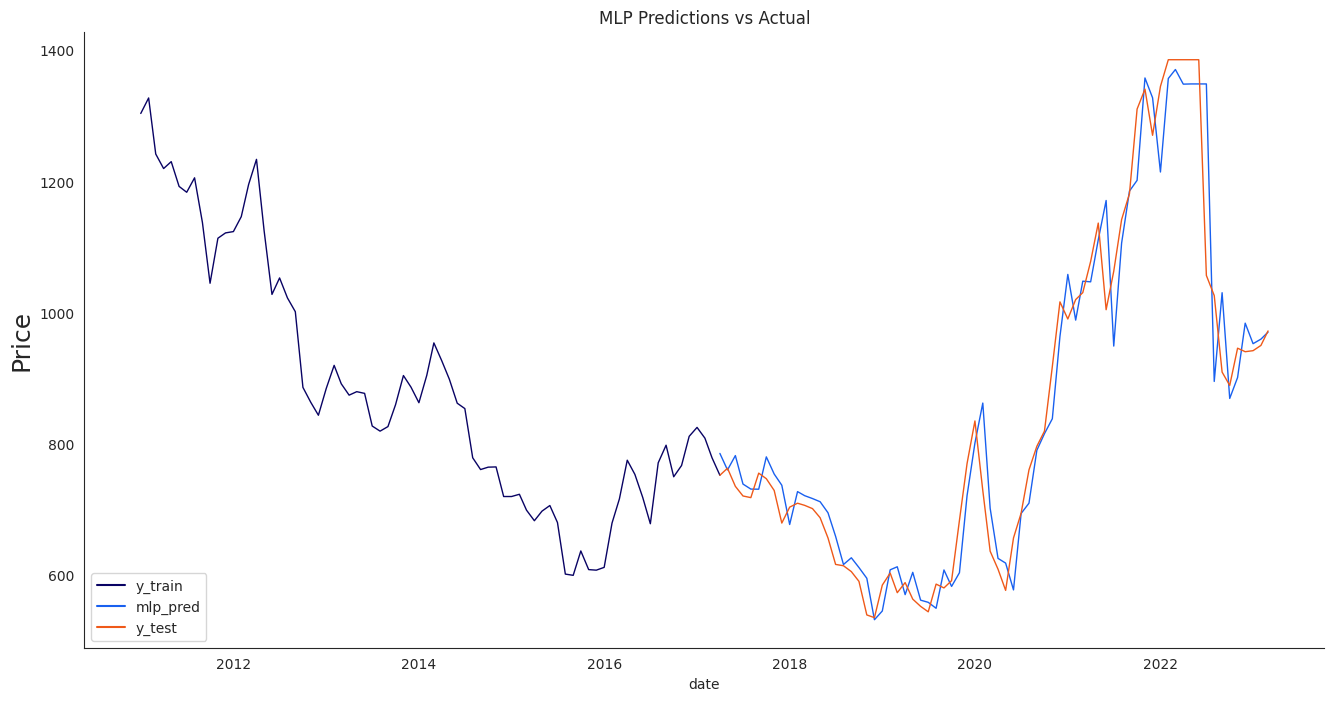

In [127]:
# The date starting from which the date is presented
display_start_date = "2010-12" 

#
train = pd.DataFrame(train_df[:train_data_len + 1]).rename(columns={'cpo_pri': 'y_train'})
valid = pd.DataFrame(train_df[train_data_len:]).rename(columns={'cpo_pri': 'y_test'})
valid.insert(1, "mlp_pred", mlp_pred, True)
valid.insert(1, "residuals", valid["mlp_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in on a specific timeframe.
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8), sharex=True)
plt.title("MLP Predictions vs Actual")
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
plt.ylabel(featurename, fontsize=18)
sns.lineplot(data=df_union_zoom[['y_train', 'mlp_pred', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

###Performing Grid Search Operation